In [1]:
## UROP exploration
# Train agent with a certain gym environment
# Write a training function
# Write Online Test function 
# Functions for measuring al the different transfer learning metrics
# Test with 2 different gym environment
# Test new reward **1
# Test 
# Online Train and test function

In [2]:
import time
from models.BaseAgent import BaseAgent
import gymnasium as gym
import torch
import numpy as np


def train(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []
    reward_user_comfort = []
    reward_power = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        ep_comfort_rewards = 0
        ep_power_rewards = 0
        is_done = False

        i = 0
        while not is_done:
            start = time.time()
            start_a = time.time()
            action = agent.select_action(state)
            end_a = time.time()
            # print(f'Action selection duration:{end_a-start_a}')
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            ep_comfort_rewards += info['comfort_score']
            ep_power_rewards += info['power_score']
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            agent.memorize(state, action, next_state, reward)
            state = next_state
            start_o = time.time()
            agent.optimize_model()
            end_o = time.time()
            # print(f'Optimization selection duration:{end_o-start_o}')

            end = time.time()
            # print(f'Iteration duration:{end-start}')
            print('\n')

        rewards.append(ep_rewards.item())
        reward_user_comfort.append(ep_comfort_rewards)
        reward_power.append(ep_power_rewards)
                


    # Return agent, and 3 list of episodic int rewards (len(rewards) = episodes)
    return agent, rewards, reward_user_comfort, reward_power

In [12]:
from gym_examples.utils.population import PopulationSimulation
from models.HITLDQNAgent import HITLDQNAgent
# Initialise training environment

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 100, 20)
# w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300) 100:1
env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1000, w_energy=1)
print("######------------------------------------Resetting environment...------------------------------------######")
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDQNAgent(n_observations, n_actions, device)

NUM_EPISODES = 100 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards, reward_user_comfort, reward_power = train(agent, env, NUM_EPISODES, device, True)


######------------------------------------Resetting environment...------------------------------------######
######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
PMV:10.293632683332598, 0,10.293632683332598


PMV:27.409629099077478, 10.293632683332598,17.11599641574488


PMV:26.170318394904147, 27.409629099077478,-1.239310704173331


PMV:14.154088094673543, 26.170318394904147,-12.016230300230603


PMV:29.271596217001846, 14.154088094673543,15.117508122328303


PMV:25.39862525416807, 29.271596217001846,-3.872970962833776


PMV:22.838059482264445, 25.39862525416807,-2.560565771903626


PMV:24.929475243180008, 22.838059482264445,2.091415760915563


PMV:30.008744857386535, 24.929475243180008,5.0792696142065275


PMV:28.031963040638452, 30.008744857386535,-1.9767818167480833


PMV:15.416299049793325, 28.031963040638452,-12.615663990845126


PMV:30

In [13]:
print(reward_user_comfort)
print(reward_power)

[15910.994248568379, 8223.659948698261, -9336.257669436163, 4785.6239432350785, 2465.1316078903506, 7118.728377295831, -13563.2429598512, 19405.352044199353, -19083.88973670273, 18777.19959003358, -11063.758724362922, -2815.341483887245, -490.88798038797086, 10496.238881369969, -6228.353750139335, -1821.9411384810846, 8713.966910833535, -10642.128155692226, 5999.604901436778, -7561.715607892588, -2320.9890631362714, 4046.7645194069273, 6191.38110264702, -607.6054588368643, 1597.5029468260036, 3573.953911110808, -7179.638241572887, -6595.973247937898, 14599.936107806392, -2184.90697697219, -3835.074591044396, -11243.602668095225, -2759.639334552301, 9729.222881629286, 10258.85281273482, -7634.2252758347795, 7048.340604264143, -4994.759938031903, 4986.179947659653, -459.34964250561006, 2430.634724890395, -11271.953581846688, 2260.907885570024, 7343.025242744974, -20830.837675729425, 19646.04942893983, -2036.9830048248766, 665.0105066178012, 690.6982904319912, -13329.622191660965, 9067.73

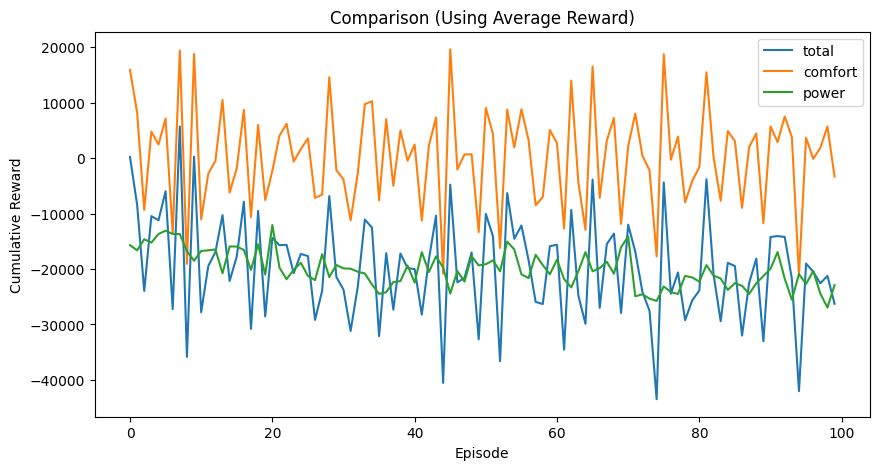

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.plot(reward_user_comfort, label='comfort')
plt.plot(reward_power, label='power')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

In [6]:
def test(agent:BaseAgent, env:gym.Env, episodes: int, device):
    rewards = []
    reward_user_comfort = []
    reward_power = []

    agent.set_exploring(False)
    
    for i_episode in range(episodes):
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        ep_comfort_rewards = 0
        ep_power_rewards = 0
        done = False

        i = 0
        while not done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            ep_comfort_rewards += info['comfort_score']
            ep_power_rewards += info['power_score']
            done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            state = next_state

        rewards.append(ep_rewards.item())
        reward_user_comfort.append(ep_comfort_rewards)
        reward_power.append(ep_power_rewards)
    return rewards, reward_user_comfort, reward_power

In [7]:


rewards, reward_user_comfort, reward_power = train(agent, test_env, 30, device)

NameError: name 'test_env' is not defined